# Fast AI - Pet Image classification  


This is a BentoML Demo Project based on Fast AI course v3 lesson one, training an image classifier with Fast AI that detect the different breed of cat and dog.

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

Make sure to __use GPU runtime when running this notebook in Google Colab__, you can set it in top menu: `Runtime > Change Runtime Type > Hardware accelerator`.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=nb&ea=open&el=gallery-example&dt=fastai-pet-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install bentoml
!pip install fastai

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Prepare Training Data

In [3]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/chaoyuyang/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 PosixPath('/Users/chaoyuyang/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),
 PosixPath('/Users/chaoyuyang/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),
 PosixPath('/Users/chaoyuyang/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),
 PosixPath('/Users/chaoyuyang/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg')]

In [5]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    num_workers=0,
    ds_tfms=get_transforms(),
    size=224,
    bs=bs
).normalize(imagenet_stats)

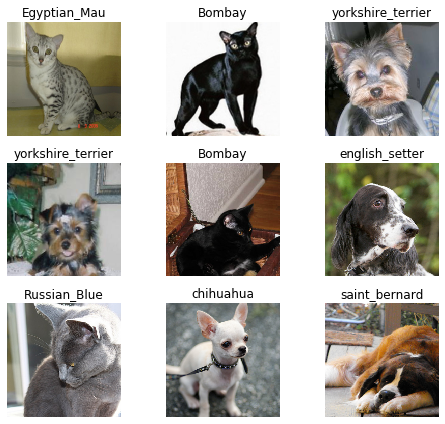

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

Now we will start training the model. For demo purpose, we will only train for 1 epoch (1 cycle through all the data).

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.608864,0.280852,0.087957,35:13


## Create BentoService for model serving

In [10]:
%%writefile pet_classification.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(conda_pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('pet_classifer')])
class PetClassification(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_classifer.predict(image)
        return str(result)

Overwriting pet_classification.py


## Save BentoService to file archive

In [11]:
# 1) import the custom BentoService defined above
from pet_classification import PetClassification

# 2) `pack` it with required artifacts
service = PetClassification.pack(pet_classifer=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2019-09-17 15:20:59,585] INFO - Successfully saved Bento 'PetClassification:2019_09_17_669e9c96' to path: /Users/chaoyuyang/bentoml/repository/PetClassification/2019_09_17_669e9c96


## Load saved BentoService for model serving

In [12]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-09-17 15:20:59,886] WARNING - Module `pet_classification` already loaded, using existing imported module.
(Category Egyptian_Mau, tensor(5), tensor([8.1198e-05, 4.7572e-03, 8.4651e-06, 7.2410e-04, 4.4823e-04, 9.9232e-01,
        1.2686e-04, 8.9391e-06, 3.2297e-05, 2.6294e-04, 1.2570e-05, 1.7887e-04,
        2.3823e-05, 1.0635e-05, 3.7823e-06, 2.6734e-05, 4.9237e-05, 3.0513e-05,
        5.5845e-05, 7.1444e-05, 3.7852e-04, 1.9912e-05, 4.3253e-06, 2.8950e-05,
        7.1766e-06, 5.2756e-06, 1.9716e-05, 2.6185e-06, 9.0641e-05, 1.7248e-05,
        9.3070e-06, 3.1759e-05, 7.4544e-05, 1.3818e-05, 2.7183e-05, 1.8018e-05,
        1.3240e-05]))


## Access your model service from Command Line

BentoML makes it very easy to install prediction service as CLI tool:

In [13]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/PetClassification/2019_09_17_669e9c96
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-zqt99zup/wheels/78/4d/a8/5c0481d65f351ee8fb0af9a297f694e3129e8ef1f9461dafa4
Successfully built PetClassification


In [14]:
# copy an image from fastai data for testing model serving service:
!mv {path_img}/yorkshire_terrier_98.jpg ./test.jpg

In [15]:
!PetClassification predict --input=test.jpg

(Category yorkshire_terrier, tensor(36), tensor([8.0540e-06, 6.4979e-06, 1.8887e-05, 2.5661e-06, 9.4208e-07, 1.8833e-07,
        1.0065e-06, 1.2213e-06, 9.1742e-07, 5.1153e-07, 4.0063e-05, 3.1151e-06,
        6.3092e-07, 8.0430e-06, 2.1248e-05, 2.3184e-05, 4.2662e-07, 7.0961e-07,
        2.3542e-05, 1.4102e-06, 1.4773e-06, 1.6668e-07, 4.0795e-05, 2.2057e-06,
        1.4281e-06, 1.5779e-06, 5.4577e-05, 7.1485e-07, 8.9898e-06, 1.3892e-07,
        3.6142e-07, 3.8042e-07, 1.6788e-04, 6.7132e-07, 1.0211e-06, 2.6692e-06,
        9.9955e-01]))


## Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [16]:
!bentoml serve {saved_path}

 * Serving Flask app "PetClassification" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Sep/2019 15:21:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2019 15:21:34] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2019 15:21:50] "POST /predict HTTP/1.1" 200 -
^C


Open http://127.0.0.1:5000 to see more information about the REST APIs server in your
browser.


### Send prediction requeset to the REST API server

Navigate to parent directory of the notebook(so you have reference to the `test.jpg` image), and run the following `curl` command to send the image to REST API server and get a prediction result:

```bash
curl -i \
    --request POST \
    --header "Content-Type: multipart/form-data" \
    -F "image=@test.jpg" \
    localhost:5000/predict
```